# Assessment of the correctness of OpenRoads network

OpenRoads network is not 100 % optimal input for morphometric analysis. This notebooks tests, whether transportation-related geometry (e.g. roundabouts) causes significant disruptions or not.

In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

from consolidate import consolidate, roundabouts, topology

In [2]:
user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(url)


In [3]:
x, y = 334289.32, 390468.43  # coordinates in epsg 27700
buffer = 10000  # radius in [m]

sql = f'SELECT * FROM openroads_200803 WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

df = gpd.read_postgis(sql, engine, geom_col='geometry')

<AxesSubplot:>

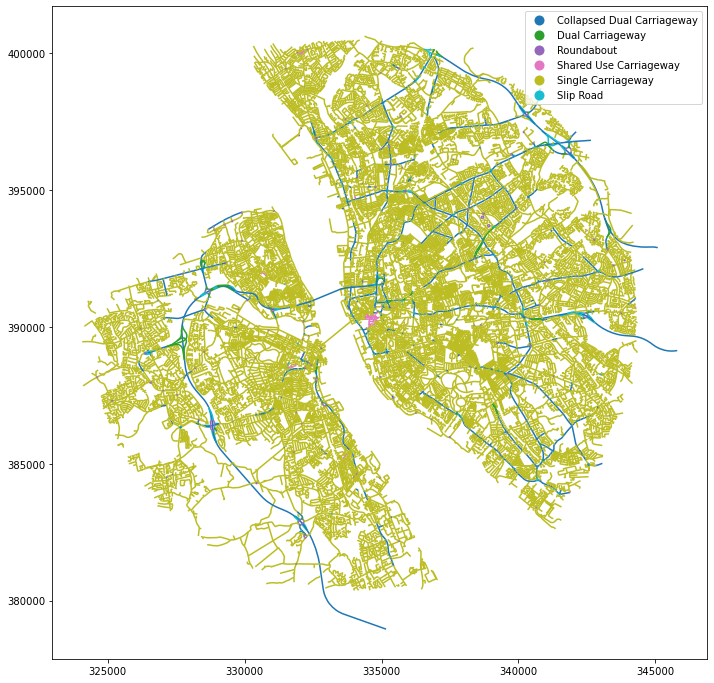

In [4]:
df.plot('formOfWay', figsize=(12, 12), legend=True)

## Topology check

Check and fix topology of the network (removal of potential nodes of degree 2).

In [5]:
topo = topology(df)

In [6]:
df.shape[0] - topo.shape[0]

1677

<AxesSubplot:>

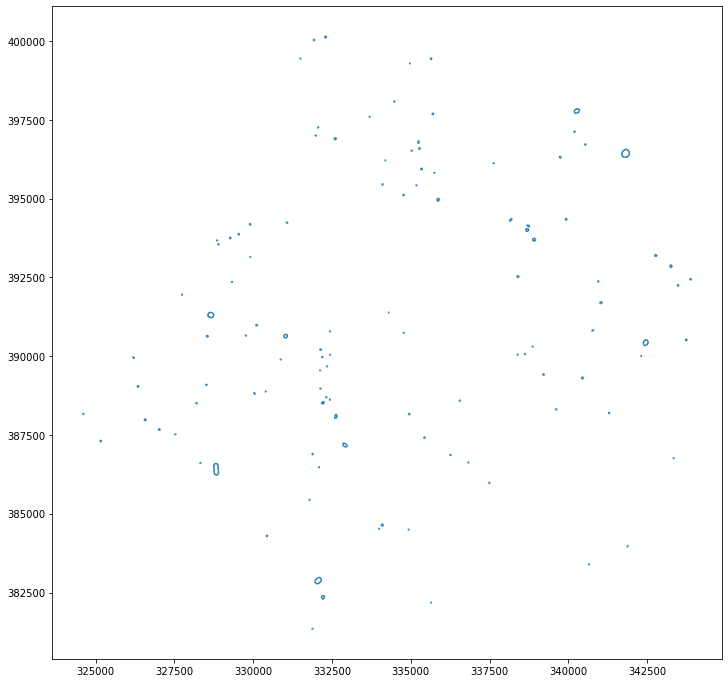

In [7]:
topo[topo.formOfWay == 'Roundabout'].plot(figsize=(12, 12))

In [8]:
(topo.formOfWay == 'Roundabout').sum()

505

505 segments marked as roundabout, where each actual roundabout is composed of ~4 segments.

In [9]:
(topo.formOfWay == 'Roundabout').sum() / topo.shape[0]

0.013554863646124115

1.3 % of all segments are marked roundabouts. Moreover, there are some other which are not explicitly marked.

## Consolidation

We will try to remove roundabouts, using `roundabouts` filter, based on a range of options. Each will be compared to the original GeoDataFrame to assess the effect on the resulting morphometric values. We will also do the visual assessment to understand the level of consolidation.

In [10]:
versions = {}

areas = range(500, 2501, 500)
compactness = np.linspace(0.7, 0.9, 5)

In [11]:
for area in areas:
    for comp in compactness:
        versions[(area, comp)] = consolidate(topo, filter_func=roundabouts, area=area, circom=comp)

In [12]:
comparison = pd.DataFrame(columns=['node_density', 'meshedness', 'l_mesh_mean', 'l_mesh_median', 'l_mesh_dev', 'l_close_mean', 'l_close_median', 'l_close_dev'])

In [13]:
G = mm.gdf_to_nx(topo)
comparison.loc['original', 'meshedness'] = mm.meshedness(G, radius=None)
G = mm.subgraph(G, meshedness=True, cds_length=False, mean_node_degree=False, proportion={0: False, 3: False, 4: False}, cyclomatic=False, edge_node_ratio=False, gamma=False, local_closeness=True, closeness_weight=None, verbose=True)
vals = list(nx.get_node_attributes(G, 'meshedness').values())
comparison.loc['original', 'l_mesh_mean'] = np.mean(vals)
comparison.loc['original', 'l_mesh_median'] = np.median(vals)
comparison.loc['original', 'l_mesh_dev'] = np.std(vals)
vals = list(nx.get_node_attributes(G, 'local_closeness').values())
comparison.loc['original', 'l_close_mean'] = np.mean(vals)
comparison.loc['original', 'l_close_median'] = np.median(vals)
comparison.loc['original', 'l_close_dev'] = np.std(vals)
comparison.loc['original', 'node_density'] = nx.number_of_nodes(G) / topo.length.sum()

100%|██████████| 29166/29166 [01:01<00:00, 477.43it/s]


In [14]:
for opt in versions.keys():
    G = mm.gdf_to_nx(versions[opt])
    comparison.loc[str(opt), 'meshedness'] = mm.meshedness(G, radius=None)
    G = mm.subgraph(G, meshedness=True, cds_length=False, mean_node_degree=False, proportion={0: False, 3: False, 4: False}, cyclomatic=False, edge_node_ratio=False, gamma=False, local_closeness=True, closeness_weight=None, verbose=True)
    vals = list(nx.get_node_attributes(G, 'meshedness').values())
    comparison.loc[str(opt), 'l_mesh_mean'] = np.mean(vals)
    comparison.loc[str(opt), 'l_mesh_median'] = np.median(vals)
    comparison.loc[str(opt), 'l_mesh_dev'] = np.std(vals)
    vals = list(nx.get_node_attributes(G, 'local_closeness').values())
    comparison.loc[str(opt), 'l_close_mean'] = np.mean(vals)
    comparison.loc[str(opt), 'l_close_median'] = np.median(vals)
    comparison.loc[str(opt), 'l_close_dev'] = np.std(vals)
    comparison.loc[str(opt), 'node_density'] = nx.number_of_nodes(G) / versions[opt].length.sum()

100%|██████████| 29095/29095 [01:02<00:00, 462.68it/s]


In [15]:
comparison

,node_density,meshedness,l_mesh_mean,l_mesh_median,l_mesh_dev,l_close_mean,l_close_median,l_close_dev
original,0.00872288,0.138718,0.0936928,0.0909091,0.0598759,0.000311968,0.000308589,0.000126856
"(500, 0.7)",0.00871223,0.138793,0.0938334,0.0909091,0.059319,0.000312618,0.000309023,0.000127038
"(500, 0.75)",0.008713,0.138843,0.0938725,0.0909091,0.0593614,0.000312571,0.000308981,0.000127022
"(500, 0.8)",0.00871329,0.138867,0.09389,0.0917431,0.0593639,0.000312542,0.00030896,0.00012702
"(500, 0.85)",0.00871536,0.138898,0.0939209,0.0917431,0.0593616,0.000312438,0.000308875,0.000126935
"(500, 0.9)",0.0087163,0.138948,0.0939607,0.0917431,0.0593366,0.000312392,0.000308833,0.000126881
"(1000, 0.7)",0.00869416,0.138441,0.0935087,0.0909091,0.0592928,0.000313579,0.000309811,0.000127631
"(1000, 0.75)",0.00869585,0.138506,0.0935517,0.0909091,0.0593331,0.000313472,0.000309725,0.000127591
"(1000, 0.8)",0.00869662,0.138539,0.0935751,0.0909091,0.0593398,0.000313421,0.000309683,0.000127576
"(1000, 0.85)",0.00870017,0.138592,0.0936287,0.0909091,0.0593478,0.000313263,0.000309534,0.000127454


In [16]:
deviations = pd.DataFrame()

In [17]:
for c in comparison.columns:
    deviations[c] = (comparison.iloc[1:][c] - comparison.loc['original', c]).abs() / comparison.loc['original', c]

In [18]:
(deviations > 0.01).any()

node_density      False
meshedness        False
l_mesh_mean       False
l_mesh_median     False
l_mesh_dev        False
l_close_mean      False
l_close_median    False
l_close_dev       False
dtype: bool

In [19]:
deviations

,node_density,meshedness,l_mesh_mean,l_mesh_median,l_mesh_dev,l_close_mean,l_close_median,l_close_dev
"(500, 0.7)",0.00122095,0.000541469,0.00150064,0,0.00930172,0.0020816,0.00140777,0.00142786
"(500, 0.75)",0.00113175,0.000899067,0.00191866,0,0.00859282,0.00193302,0.00127026,0.00130553
"(500, 0.8)",0.00109907,0.00107783,0.00210498,0.00917431,0.00855261,0.00184017,0.00120151,0.00128813
"(500, 0.85)",0.00086104,0.0012978,0.00243503,0.00917431,0.00859028,0.00150519,0.000926625,0.000615929
"(500, 0.9)",0.00075323,0.00165512,0.00285943,0.00917431,0.00900818,0.00135845,0.000789239,0.00019092
"(1000, 0.7)",0.00329184,0.00199711,0.00196469,0,0.0097388,0.00516262,0.00395869,0.00610623
"(1000, 0.75)",0.00309864,0.00152759,0.00150569,0,0.00906542,0.0048192,0.00368229,0.00579156
"(1000, 0.8)",0.00301004,0.00129292,0.0012559,0,0.00895485,0.00465568,0.00354415,0.00567496
"(1000, 0.85)",0.00260243,0.000906017,0.000684244,0,0.00882143,0.00414957,0.00306094,0.00470633
"(1000, 0.9)",0.00119321,0.00121532,0.0017532,0.00763359,0.00890449,0.00220477,0.00133901,0.00121683


The negative effect of transportation-related geometry seems to be insignificant, hence the network should be only topologically corrected.